In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
import os
import random

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
print(f"--- Randomness fixed with seed: {SEED} ---")

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle

# Keras Imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Add src to path
sys.path.append('../src')
from src.preprocess import normalize_flux
# Import our updated augmentation tool
from src.augmentation import inject_transit_signal

print(f"TensorFlow Version: {tf.__version__}")

--- Randomness fixed with seed: 42 ---
TensorFlow Version: 2.20.0


In [2]:
TRAIN_PATH = '../data/raw/train.csv'
TEST_PATH = '../data/raw/test.csv'
print("Loading data...")
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)
df_train['LABEL'] = df_train['LABEL'].map({1: 0, 2: 1})
df_test['LABEL'] = df_test['LABEL'].map({1: 0, 2: 1})

# --- 2. Realistic Data Augmentation (v7) ---
print("Starting realistic data augmentation...")
N_AUGMENTATIONS = 1000
# NEW HYPERPARAMETER TO TUNE
# We guess a noise level (std dev) to add. 0.05 is a reasonable start.
NOISE_LEVEL = 0.05

# Separate original positive and negative examples
df_train_pos = df_train[df_train['LABEL'] == 1]
df_train_neg = df_train[df_train['LABEL'] == 0]

# --- A. Process original positives (37 real ones) ---
print(f"Processing {len(df_train_pos)} original positive samples...")
X_train_pos_raw = df_train_pos.drop('LABEL', axis=1).fillna(0)
X_train_pos_norm = X_train_pos_raw.apply(normalize_flux, axis=1).values
y_train_pos = df_train_pos['LABEL'].values

# --- B. Create NEW realistic augmented positives ---
print(f"Creating {N_AUGMENTATIONS} new realistic (noisy) positive samples...")
augmented_flux_list = []
df_train_neg_raw_for_sampling = df_train_neg.drop('LABEL', axis=1).fillna(0)

for i in range(N_AUGMENTATIONS):
    sample_neg_series = df_train_neg_raw_for_sampling.sample(1).values[0]
    normalized_neg_series = normalize_flux(sample_neg_series)

    # --- KEY CHANGE: Call with noise_level ---
    augmented_series = inject_transit_signal(
        normalized_neg_series,
        noise_level=NOISE_LEVEL
    )
    augmented_flux_list.append(augmented_series)

X_train_augmented = np.array(augmented_flux_list)
y_train_augmented = np.ones(N_AUGMENTATIONS, dtype=int)

# --- C. Process all negative samples ---
print(f"Processing {len(df_train_neg)} original negative samples...")
X_train_neg_raw = df_train_neg.drop('LABEL', axis=1).fillna(0)
X_train_neg_norm = X_train_neg_raw.apply(normalize_flux, axis=1).values
y_train_neg = df_train_neg['LABEL'].values

# --- D. Combine and Shuffle ---
print("Combining and shuffling final training set...")
X_train_final = np.concatenate([X_train_neg_norm, X_train_pos_norm, X_train_augmented])
y_train_final = np.concatenate([y_train_neg, y_train_pos, y_train_augmented])
X_train_final, y_train_final = shuffle(X_train_final, y_train_final, random_state=SEED)

total_samples = len(y_train_final)
total_positives = len(y_train_pos) + len(y_train_augmented)
total_negatives = len(y_train_neg)
print(f"New training set size: {total_samples} samples")
print(f" -> Negatives (0): {total_negatives}")
print(f" -> Positives (1): {total_positives} (Balance: {total_positives/total_samples:.1%})")

# --- 3. Process Test Data (Unchanged) ---
print("Processing test data (unchanged)...")
X_test_raw = df_test.drop('LABEL', axis=1).fillna(0)
X_test_normalized = X_test_raw.apply(normalize_flux, axis=1).values
y_test = df_test['LABEL'].values

# --- 4. Final CNN Prep (Reshaping) ---
print("Reshaping data for CNN...")
X_train_cnn = X_train_final[:, :, np.newaxis]
X_test_cnn = X_test_normalized[:, :, np.newaxis]

# --- 5. Recalculate Class Weights ---
print("Recalculating class weights...")
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_final),
    y=y_train_final
)
class_weight_dict = {
    0: class_weights[0],
    1: class_weights[1]
}
print(f"New Class Weights: {class_weight_dict}")
print("--- Data preparation complete ---")

Loading data...
Starting realistic data augmentation...
Processing 37 original positive samples...
Creating 1000 new realistic (noisy) positive samples...
Processing 5050 original negative samples...
Combining and shuffling final training set...
New training set size: 6087 samples
 -> Negatives (0): 5050
 -> Positives (1): 1037 (Balance: 17.0%)
Processing test data (unchanged)...
Reshaping data for CNN...
Recalculating class weights...
New Class Weights: {0: np.float64(0.6026732673267327), 1: np.float64(2.9349083895853423)}
--- Data preparation complete ---


In [3]:
print("Building v7 model architecture (same as v5/v6)...")
INPUT_SHAPE = (X_train_cnn.shape[1], 1)

model_v7 = Sequential([
    Input(shape=INPUT_SHAPE),
    Conv1D(filters=8, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2), BatchNormalization(),
    Conv1D(filters=16, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2), BatchNormalization(),
    Conv1D(filters=32, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2), BatchNormalization(),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.6),
    Dense(1, activation='sigmoid')
])
model_v7.summary()

# --- 4. Callbacks & Compilation ---
MODEL_SAVE_PATH = '../models/cnn_model_v7_realistic_aug.keras'
checkpoint_cb = ModelCheckpoint(filepath=MODEL_SAVE_PATH, monitor='val_pr_auc', mode='max', save_best_only=True, verbose=1)
# Let's increase patience. Learning on noisy data is harder.
early_stopping_cb = EarlyStopping(monitor='val_pr_auc', mode='max', patience=10, verbose=1, restore_best_weights=True)
CALLBACK_LIST = [checkpoint_cb, early_stopping_cb]

print("Compiling v7 model...")
pr_auc_metric = AUC(curve='PR', name='pr_auc')
model_v7.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', pr_auc_metric]
)
print("Model compiled.")

# --- 5. Train the Model (v7) ---
print("Starting v7 (realistic augmented) training...")
history_v7 = model_v7.fit(
    X_train_cnn,
    y_train_final, # <-- Use the new augmented labels
    epochs=50,
    batch_size=32,
    validation_data=(X_test_cnn, y_test), # <-- Validate on the REAL test data
    class_weight=class_weight_dict,
    callbacks=CALLBACK_LIST
)
print("Training finished.")

Building v7 model architecture (same as v5/v6)...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 3193, 8)        │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1596, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1596, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1592, 16)       │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 796, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 796, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 792, 32)        │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 396, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 396, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12672)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       405,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,089 (1.56 MB)

 Trainable params: 408,977 (1.56 MB)

 Non-trainable params: 112 (448.00 B)

Compiling v7 model...
Model compiled.
Starting v7 (realistic augmented) training...
Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4760 - loss: 1.6505 - pr_auc: 0.1736
Epoch 1: val_pr_auc improved from None to 0.00862, saving model to ../models/cnn_model_v7_realistic_aug.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.5152 - loss: 1.7742 - pr_auc: 0.1662 - val_accuracy: 0.9860 - val_loss: 0.6865 - val_pr_auc: 0.0086
Epoch 2/50
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7637 - loss: 1.0673 - pr_auc: 0.1969
Epoch 2: val_pr_auc did not improve from 0.00862
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.7578 - loss: 0.9610 - pr_auc: 0.1924 - val_accuracy: 0.9825 - val_loss: 0.6853 - val_pr_auc: 0.0085
Epoch 3/50
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7965 - loss: 0.8540 - pr_auc: 0.2003
Epoch 3: val_pr_auc improved from 0.00862 to 0.00869, saving model to ../models/cnn_model_v7_realistic_aug.keras
191/191 ━━━━━━━━━━━

Evaluating v7 model (with best weights)...
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

Confusion Matrix (CNN v7):
[[565   0]
 [  5   0]]

Classification Report (CNN v7):
               precision    recall  f1-score   support

No Planet (0)       0.99      1.00      1.00       565
   Planet (1)       0.00      0.00      0.00         5

     accuracy                           0.99       570
    macro avg       0.50      0.50      0.50       570
 weighted avg       0.98      0.99      0.99       570


Plotting training history...


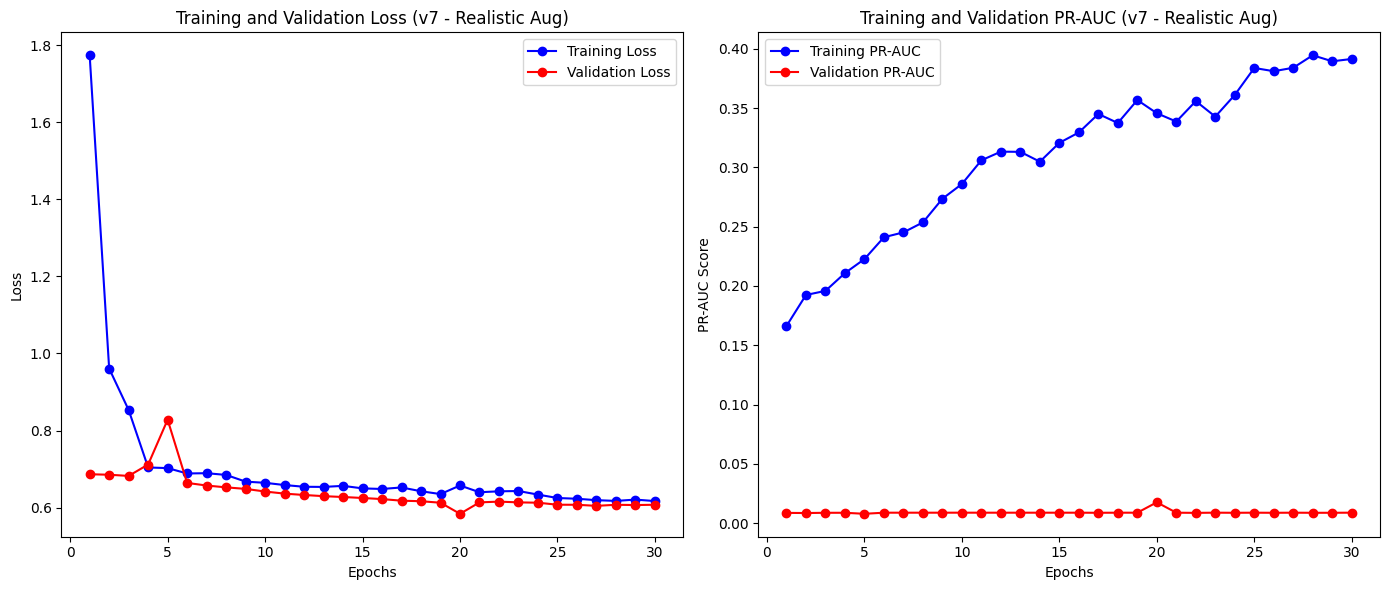

In [4]:
print("Evaluating v7 model (with best weights)...")

y_pred_proba_cnn_v7 = model_v7.predict(X_test_cnn).flatten()
y_pred_cnn_v7 = (y_pred_proba_cnn_v7 > 0.5).astype(int)

print("\nConfusion Matrix (CNN v7):")
cm_cnn_v7 = confusion_matrix(y_test, y_pred_cnn_v7)
print(cm_cnn_v7)

print("\nClassification Report (CNN v7):")
print(classification_report(y_test, y_pred_cnn_v7, target_names=['No Planet (0)', 'Planet (1)'], zero_division=0))

# --- 7. Plot Training History ---
print("\nPlotting training history...")
history_dict = history_v7.history
loss = history_dict['loss']; val_loss = history_dict['val_loss']
pr_auc = history_dict['pr_auc']; val_pr_auc = history_dict['val_pr_auc']
actual_epochs = len(loss)
epochs_range = range(1, actual_epochs + 1)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss (v7 - Realistic Aug)')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs_range, pr_auc, 'bo-', label='Training PR-AUC')
plt.plot(epochs_range, val_pr_auc, 'ro-', label='Validation PR-AUC')
plt.title('Training and Validation PR-AUC (v7 - Realistic Aug)')
plt.xlabel('Epochs'); plt.ylabel('PR-AUC Score'); plt.legend()
plt.tight_layout()
plt.show()